In [12]:
import pandas as pd
from astroquery.mast import Observations, Catalogs
import matplotlib.pyplot as plt
import numpy as np

# import glob
# from astropy.io import ascii
# from astropy.table import Table, join, vstack
# from astropy.io import fits
# import lightkurve as lk
# from operator import itemgetter

In [ ]:
# NOTE TO ME: CHANGE THIS TO TAKE IN ONE SECTOR AT A TIME...ELIMINATE
# NEED TO COMMENT/UNCOMMENT LINES IN EVERY CELL

## Notebook Goals:
- 1) gets/opens sector tic id lists
- 2) downloads tic catalog based on tic ids (temp cuts, get ra/dec)
- 3) uses ra/dec for mast query to get data urls
- 4) creates shell script to download raw lc files 

- 5) merges/matches pipeline stats into tic catalog

- 6) Download vilanova Kepler EB catalog lcs

### Useful Functions

In [2]:
# unique item finder

def uniquefinder(mylist):
    seen = {}
    dupes = []
    uniq_tics = []
    for x in mylist:
        if x not in seen:
            seen[x] = 1
            uniq_tics.append(x)
        else:
            if seen[x] == 1:
                dupes.append(x)
            seen[x] += 1
    uniques = len(uniq_tics)
    print('there are {} unique tics. Use the first output dictionary'.format(uniques), \
          'to see number of occurances for duplicates')
    return seen, uniq_tics

In [3]:
#for ease of switching file location

externalpath = '/Volumes/Seagate-stars/'

# ONE

In [4]:
## open tic id lists per sector
# lists downloaded from https://tess.mit.edu under top menu item "Observations"-->"Target Lists" OR Sectors"-->"Sector #"--->scroll down to list dl .txt or .csv
# NOTE: weird error with ^^ those files, need to 1)add space after "colname, " AND 2)use 'skiprows' below to get read by pandas

sec14_file = pd.read_csv('data/SECTORS/all_targets_S014_v1.csv',skiprows=5) #overlaps kepler
sec15_file = pd.read_csv('data/SECTORS/all_targets_S015_v1.csv',skiprows=5) #overlaps kepler
sec14_file 
# sec15_file

,TICID,Camera,CCD,Tmag,RA,Dec
0,7582594,2,3,8.57,272.3966,45.8308
1,7582633,2,3,9.92,272.3288,45.9244
2,7582634,2,3,10.48,272.3307,45.9255
3,7583285,2,2,11.30,272.3711,47.2259
4,7584049,2,2,8.50,272.5282,47.0887
...,...,...,...,...,...,...
19995,1980752885,2,1,16.91,303.1632,60.2862
19996,1980968952,2,1,8.65,301.3995,63.7061
19997,1980968953,2,1,8.76,301.3993,63.7056
19998,1981207128,2,1,7.88,300.4913,65.8903


In [5]:
#pull tic ids
ticid_sec15 = sec15_file['TICID'].to_numpy() #full sample
ticid_sec14 = sec14_file['TICID'].to_numpy() #full sample


len(ticid_sec15),len(ticid_sec14)

(20000, 20000)

 # TWO

In [6]:
## get tic catalog to do teff cut prior to lc dl
catalog_data_sec15 = Catalogs.query_criteria(catalog='Tic',ID=ticid_sec15)
catalog_data_sec14 = Catalogs.query_criteria(catalog='Tic',ID=ticid_sec14)



#rename TIC ID column to match target name from Mast file for matching ease later
catalog_data_sec15.rename_column('ID', 'target_name')
catalog_data_sec14.rename_column('ID', 'target_name')
# catalog_data_sec15#[0:5] # astropy.table
catalog_data_sec14[0:5]

target_name,version,HIP,TYC,UCAC,TWOMASS,SDSS,ALLWISE,GAIA,APASS,KIC,objType,typeSrc,ra,dec,POSflag,pmRA,e_pmRA,pmDEC,e_pmDEC,PMflag,plx,e_plx,PARflag,gallong,gallat,eclong,eclat,Bmag,e_Bmag,Vmag,e_Vmag,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,TWOMflag,prox,w1mag,e_w1mag,w2mag,e_w2mag,w3mag,e_w3mag,w4mag,e_w4mag,GAIAmag,e_GAIAmag,Tmag,e_Tmag,TESSflag,SPFlag,Teff,e_Teff,logg,e_logg,MH,e_MH,rad,e_rad,mass,e_mass,rho,e_rho,lumclass,lum,e_lum,d,e_d,ebv,e_ebv,numcont,contratio,disposition,duplicate_id,priority,eneg_EBV,epos_EBV,EBVflag,eneg_Mass,epos_Mass,eneg_Rad,epos_Rad,eneg_rho,epos_rho,eneg_logg,epos_logg,eneg_lum,epos_lum,eneg_dist,epos_dist,distflag,eneg_Teff,epos_Teff,TeffFlag,gaiabp,e_gaiabp,gaiarp,e_gaiarp,gaiaqflag,starchareFlag,VmagFlag,BmagFlag,splists,e_RA,e_Dec,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,objID
str10,str8,int64,str12,str10,str16,str19,str19,str19,str8,int64,str4,str11,float64,float64,str11,float64,float64,float64,float64,str6,float64,float64,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,float64,float64,float64,float64,int64,float64,str5,str1,float64,float64,float64,str9,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str6,float64,float64,str6,float64,float64,float64,float64,int64,str1,str11,str8,str15,float64,float64,float64,float64,float64,float64,int64,int64,str9
86378010,20190415,--,4142-00290-1,777-026823,09394442+6517542,1237663531340005408,J093944.40+651753.6,1064936836101769088,59791205,--,STAR,tmgaia2,144.935072883975,65.2984086893993,tmgaia2,-9.49785,0.030933,-50.0193,0.0393627,gaia2,7.347,0.0276672,gaia2,147.424919778241,41.5663317476576,120.458150928839,47.5639330380079,11.905,0.116,11.201,0.008,15.7385,0.0107012,11.7932,0.000900966,11.018,0.000842068,10.8461,0.0016471,11.4257,0.00286948,9.817,0.022,9.447,0.022,9.365,0.02,AAA-222-111-000-0-0,nan,9.327,0.022,9.382,0.02,9.366,0.041,8.371,nan,11.0374,0.000649,10.5243,0.0061,rered,gaia2,5328.0,128.324,4.50918,0.0794761,nan,nan,0.883289,0.0493643,0.919,0.114993,1.33354,0.296112,DWARF,0.566444159,0.01598915,135.578,0.5125,0.0122598,0.007237535,35,0.00206631725,--,--,0.00222908775,0.00544062,0.00903445,panstarrs,0.130945,0.0990415,0.0502447,0.0484839,0.296146,0.296078,0.0807992,0.0781531,0.0195403,0.012438,0.511,0.514,bj2018,122.397,134.251,dered,11.4717,0.001056,10.482,0.000778,1,--,tycho2v3,tycho2b3,--,0.569639411354915,0.610494489824118,144.934975027373,65.2981933285543,0.0151389867404792,0.0213272187166399,1,0,138545460
841257506,20190415,--,--,--,--,--,--,1070737855153980160,--,--,STAR,gaia2,144.124922853682,68.1974732470316,gaia2,31.5066,0.142326,-78.8204,0.170878,gaia2,6.11102,0.143933,gaia2,144.270337689575,39.8948279604807,117.874238210289,49.9316253628915,nan,nan,17.459,0.0459,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,17.4377,0.001328,17.5892,0.0309,rered,gaia2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,--,nan,nan,163.008,3.8565,0.0456363,0.0006623975,--,nan,--,--,nan,0.000654138,0.000670657,schlegel,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,3.767,3.946,bj2018,nan,nan,--,17.3286,0.008235,17.4968,0.008622,--,--,gaia2,--,--,2.66521280409442,2.65105888875672,144.125288093882,68.1971338818192,0.0777898076546595,0.113945586904639,--,0,138525904
430246167,20190415,47119,4389-01750-1,822-015688,09360674+7419075,--,J093606.72+741907.4,1121271791819779072,--,--,STAR,tmgaia2,144.028224206007,74.3188079331561,tmgaia2,-20.0635,0.0709739,-24.3244,0.0714913,gaia2,6.52852,0.0477083,gaia2,137.628695

In [7]:
# do temp cut
#sec15
tempcut_sec15 = catalog_data_sec15[catalog_data_sec15['Teff']<6500]
tics_sec15 = list(tempcut_sec15['target_name']) #strings #cool stars only
#sec14
tempcut_sec14 = catalog_data_sec14[catalog_data_sec14['Teff']<6500]
tics_sec14 = list(tempcut_sec14['target_name']) #strings #cool stars only


print('Sector-15 full sample size:',len(catalog_data_sec15))
print('Sector-15 after temp cut size:',len(tempcut_sec15))
print('Sector-14 full sample size:',len(catalog_data_sec14))
print('Sector-14 after temp cut size:',len(tempcut_sec14))

/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


Sector-15 full sample size: 20000
Sector-15 after temp cut size: 16367
Sector-14 full sample size: 20000
Sector-14 after temp cut size: 16326


# THREE

RA-sec15 (min/max): 165.406361318066 334.524244023761
DEC-sec15 (min/max): 19.9359797307246 80.8258934762107
RA-sec45 (min/max): 129.860802745736 313.263354607941
DEC-sec14 (min/max): 14.6338868250958 87.2147697265926


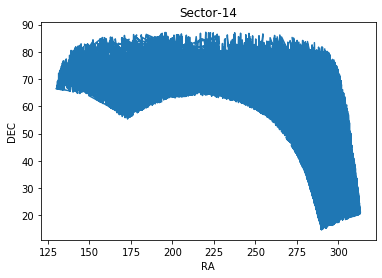

In [8]:
#determine RA/DEC bounds for mast url query

ra_sec15 = tempcut_sec15['ra']
dec_sec15 = tempcut_sec15['dec']
print('RA-sec15 (min/max):',min(ra_sec15),max(ra_sec15))
print('DEC-sec15 (min/max):',min(dec_sec15),max(dec_sec15))

ra_sec14 = tempcut_sec14['ra']
dec_sec14 = tempcut_sec14['dec']
print('RA-sec45 (min/max):',min(ra_sec14),max(ra_sec14))
print('DEC-sec14 (min/max):',min(dec_sec14),max(dec_sec14))

# plt.plot(ra_sec15,dec_sec15);plt.xlabel('RA');plt.ylabel('DEC');plt.title('Sector-15');
plt.plot(ra_sec14,dec_sec14);plt.xlabel('RA');plt.ylabel('DEC');plt.title('Sector-14');

In [9]:
## open mast query file to match ticids then get lc url
# got from mast at https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html
# then top menu 'Advanced Search' and query ra/dec bounds


# supposed to be full Northern Hemisphere 
northern_hem_mast_file = pd.read_csv('data/SECTORS/MAST_2020-08-06T2317.csv',skiprows=4) #dec=(19-81),filters=TESS
print('northern hemp total number of files:',len(northern_hem_mast_file))
northern_hem_mast_file[0:5]

northern hemp total number of files: 249883


,dataproduct_type,calib_level,obs_collection,obs_id,target_name,s_ra,s_dec,t_min,t_max,t_exptime,...,provenance_name,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,intentType,obsid,objID
0,timeseries,3,TESS,tess2019331140908-s0019-0000000310341755-0164-s,310341755,82.994473,51.395750,58815.575983,58840.648195,120,...,SPOC,CIRCLE ICRS 82.99447268 51.39575048 0.00138889,NaN,mast:TESS/product/tess2019331140908-s0019-0000...,PUBLIC,False,NaN,science,17000696530,17003836598
1,timeseries,3,TESS,tess2019331140908-s0019-0000000243353559-0164-s,243353559,290.355795,57.766808,58815.575983,58840.648195,120,...,SPOC,CIRCLE ICRS 290.35579495 57.76680784 0.00138889,NaN,mast:TESS/product/tess2019331140908-s0019-0000...,PUBLIC,False,NaN,science,17000696546,17003836630
2,timeseries,3,TESS,tess2019331140908-s0019-0000000127968322-0164-s,127968322,81.726321,35.457272,58815.575983,58840.648195,120,...,SPOC,CIRCLE ICRS 81.72632138 35.45727236 0.00138889,NaN,mast:TESS/product/tess2019331140908-s0019-0000...,PUBLIC,False,NaN,science,17000696698,17003836934
3,timeseries,3,TESS,tess2019331140908-s0019-0000000310973373-0164-s,310973373,85.024499,49.066400,58815.575983,58840.648195,120,...,SPOC,CIRCLE ICRS 85.02449863 49.06640044 0.00138889,NaN,mast:TESS/product/tess2019331140908-s0019-0000...,PUBLIC,False,NaN,science,17000698786,17003843664
4,timeseries,3,TESS,tess2019331140908-s0019-0000000309866670-0164-s,309866670,81.805490,53.565967,58815.575983,58840.648195,120,...,SPOC,CIRCLE ICRS 81.80548963 53.56596720 0.00138889,NaN,mast:TESS/product/tess2019331140908-s0019-0000...,PUBLIC,False,NaN,science,17000699100,17003847924


In [10]:
## match mast file with tempcut tic ids

mastid = northern_hem_mast_file['target_name'].to_numpy()
# convert types for merge
tempcut_sec15_df = tempcut_sec15.to_pandas() #make table a df for joining
tempcut_sec14_df = tempcut_sec14.to_pandas() #make table a df for joining
northern_hem_mast_file['target_name'] = northern_hem_mast_file['target_name'].astype(str) #b/c tempcut tic catalog is string IDs (and cant convert that to int for some reason?(N/A)??)


# merge ---use this table in FOUR
# mast_ticcat_merge = pd.merge(tempcut_sec15_df, northern_hem_mast_file, how='left', on='target_name') #how to only keep mytics
# print('SEC-15 before merge:',len(tempcut_sec15_df),' after merge:',len(mast_ticcat_merge),'targets')
# print('--these are different b/c includes cvz where camera4 targets are observed in multiple sectors-- \n'
#       'i.e.-this is data from more than one sector ')
mast_ticcat_merge = pd.merge(tempcut_sec14_df, northern_hem_mast_file, how='left', on='target_name') #how to only keep mytics
print('SEC-14 before merge:',len(tempcut_sec14_df),' after merge:',len(mast_ticcat_merge),'targets')


# test for how many unique tics merged
dupes, uniques = uniquefinder(mast_ticcat_merge['target_name'].to_numpy())
# print('These two better match:', len(tempcut_sec15_df),len(uniques))#'otherwise some targets have no lc datafiles')
print('These two better match:', len(tempcut_sec14_df),len(uniques))#'otherwise some targets have no lc datafiles')

/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'HIP' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'KIC' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'numcont' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'gaiaqflag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


SEC-14 before merge: 16326  after merge: 99721 targets
there are 16326 unique tics. Use the first output dictionary to see number of occurances for duplicates
These two better match: 16326 16326


# FOUR

In [13]:
## create shell text strings from mast url's

curlscript = []
for i in range(len(mast_ticcat_merge)):
    firststr = 'curl -C - -L -o '
    middlestr = str(mast_ticcat_merge['obs_id'][i]) +'_lc.fits '
    webaddy = "https://mast.stsci.edu/api/v0.1/Download/file/?uri=" 
    laststr = webaddy +str(mast_ticcat_merge['dataURL'][i])
    script = firststr + middlestr + laststr 
    #print(script)
    curlscript.append(script)
curlscript=np.array(curlscript)
curlscript.shape



(99721,)

In [ ]:
## SECTOR-15 create shell script (remove outter ''' ''' if need to rerun)

''' 


with open ('data/SECTORS/Sector_15/dl_sec15.sh', 'w') as rsh:
    for count,script in enumerate(curlscript):
        rsh.write('''\
#! /bin/bash
{}
'''.format(script))



'''

In [14]:
## SECTOR-14 create shell script (remove outter ''' ''' if need to rerun)

''' 


with open ('{}Sec14_rawLCs/dl_sec14.sh'.format(externalpath), 'w') as rsh:
    for count,script in enumerate(curlscript):
        rsh.write('''\
#! /bin/bash
{}
'''.format(script))



'''

# FIVE

# SIX

In [ ]:
##open table of kics & periods
path = externalpath #or 'data/' if on my computer

# keplers = pd.read_csv('data/KeplerEBs_file.csv',skiprows=3,header=4) #more columns
keplers2 = pd.read_csv('{}KeplerEBs/KeplerEBs_file-2'.format(path),header=1) #min columns needed
shortkep = keplers2[(keplers2['period']>.5) &(keplers2['period']<15)] # only periods within TESS likely range

print('column names:',list(shortkep.columns))
print('all EBs:',len(keplers2),'; EBs within 0-15period range:',len(shortkep))

In [ ]:
# DO ~NOT~ RUN AGAIN --DATA ALREADY DOWNLOADED

#dl data for all targets desired---every 3rd to get diverse sample (og table sorted by period lo-hi)
# path = externalpath #or 'data/' if on my computer


# import requests
# n = 3 #only dl every 3rd lc
# dl_count = 0
# for count,i in enumerate(list(shortkep['KIC'])):
#     if count % n == 0: #remainder ==0 after division by interval
#         kic = i
#         url = 'http://keplerebs.villanova.edu/data/?k={}.00&cadence=lc&data=data'.format(kic)
#         r = requests.get(url, allow_redirects=True)
#         filename = '{}KeplerEBs/KepEB_rawLCs/{}_lc.csv'.format(path,kic)
#         open(filename, 'wb').write(r.content)
#         dl_count +=1
#     else:
#         pass
# print('Total files downloaded (.5<per<15):',dl_count)
print('Total files downloaded (.5<per<15): 554'

# ----------------------TESTS--------------------------

In [ ]:
# type(tempcut_sec15),type(catalog_data_sec15)

In [ ]:
# left = pd.DataFrame({'key1': ['K0', 'K0', 'K1', 'K2'],
#                     'key2': ['K0', 'K1', 'K0', 'K1'],
#                      'A': ['A0', 'A1', 'A2', 'A3'],
#                       'B': ['B0', 'B1', 'B2', 'B3']})
# right = pd.DataFrame({'key1': ['K0', 'K1', 'K1', 'K2'],
#                        'key2': ['K0', 'K0', 'K0', 'K0'],
#                        'C': ['C0', 'C1', 'C2', 'C3'],
#                      'D': ['D0', 'D1', 'D2', 'D3']})  
# result = pd.merge(left, right, on=['key1', 'key2'])

In [ ]:
# northern_hem_mast_file['target_name'] = northern_hem_mast_file['target_name'].astype(str)


In [ ]:
# northern_hem_mast_file['target_name'].dtypes

In [ ]:
# catalog_data_sec15['target_name']=catalog_data_sec15['target_name'].astype(int)
# catalog_data_sec15

In [ ]:
# for i in catalog_data_sec15['target_name']:
# #     print(i[0])
#     if i[0] =='1':
#         print(i)